# SytheticGAN for Sythetic Dataset Generation
For this application, the Generative Neural Network was used in generating synthetic data, in this case, I used the Robinson's Retail Holdings acquired from previous activies.

### 1. Data Gathering
As previously mentioned, I will be using the Robinson's Retail holdings.

In [3]:
!pip install ydata-synthetic #This installs the needed library for TimeGAN

### 2. Preprocessing Data
The dataset will undergo some data processing such as string to text conversion, but ultimately, ydata provides a specific library for preprocessing for stock prices.

In [12]:
from os import path                                                           #Allows to create files in a certain directory
import pandas as pd                                                           #For dataframe manipulation
import numpy as np                                                            #For list manipulation
import matplotlib.pyplot as plt                                               #For plotting of data

from ydata_synthetic.synthesizers import ModelParameters                      #Defining the GAN's parameters, not configured due to time constraints.
from ydata_synthetic.preprocessing.timeseries import processed_stock          #Preprocessed the stock input data
from ydata_synthetic.synthesizers.timeseries import TimeGAN                   #Defines the model ofr the activity

In [13]:
seq_len=24                                                                    #This section defines the parameeters for the GAN model, not configured
n_seq = 6                                                                     #Due to time constraints.
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [14]:
stock = pd.read_csv("RRHI Historical Data Complete.csv")                       #This section preprocesses the csv file; which drops the "%" symbol, 
stock["Change %"] = stock["Change %"].str.replace('%', '')                     #Replaces the K and M values in vthe Vol. column with their numerical equivalents,
stock["Change %"] = pd.to_numeric(stock["Change %"])                           #and drops the date
for i in range(len(stock["Vol."])):
    if  "K" in stock.at[i,"Vol."]:
        stock.at[i,"Vol."] = stock.at[i,"Vol."].replace('K', '')
        stock.at[i,"Vol."] = float(stock.at[i,"Vol."])
    elif "M" in stock.at[i,"Vol."]:
        stock.at[i,"Vol."] = stock.at[i,"Vol."].replace('M', '')
        stock.at[i,"Vol."] = float(stock.at[i,"Vol."])*1000000/1000
stock = stock.drop(["Date"], axis=1)
stock.to_csv('Robinson Prep.csv', index=False)

In [15]:
stock_data = processed_stock("Robinson Prep.csv", seq_len=seq_len)            #Passing the compiled csv file into the preprocessing module
print(len(stock_data),stock_data[0].shape)

467 (24, 6)


### 3. Model Selection
As part of the activity, the model would be TimeGAN. 

### 4. Training the model
The dataset that has been preprocessed will be fed as data for the GAN; <br>
The link below is the file for the created model to save time for evaluation as the training time took over 30 hours. <br>
Link: https://drive.google.com/file/d/1JjRuh0qS8OfzyxLz4jPJrwVJcPpgy5-v/view?usp=sharing<br>
Please use the TIP email.

In [16]:
if path.exists('synthesizer_stock.pkl'):                                                               #Defines if a pickle model exists, if not it would train a new model.
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(stock_data, train_steps=50000)
    synth.save('synthesizer_stock.pkl') 

In [39]:
synth_data = synth.sample(len(stock_data))                                                             #Defines the synthesized data
synth_data.shape

Synthetic data generation: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


(512, 24, 6)

### 5. Model Evaluation
In order to evaluate the modell, two activities are conducted; one is a comparison of each feature of the synthetic dataset to the real dataset, and the other is training two models of the same architecture, one with real data and the other with the synthesized data.

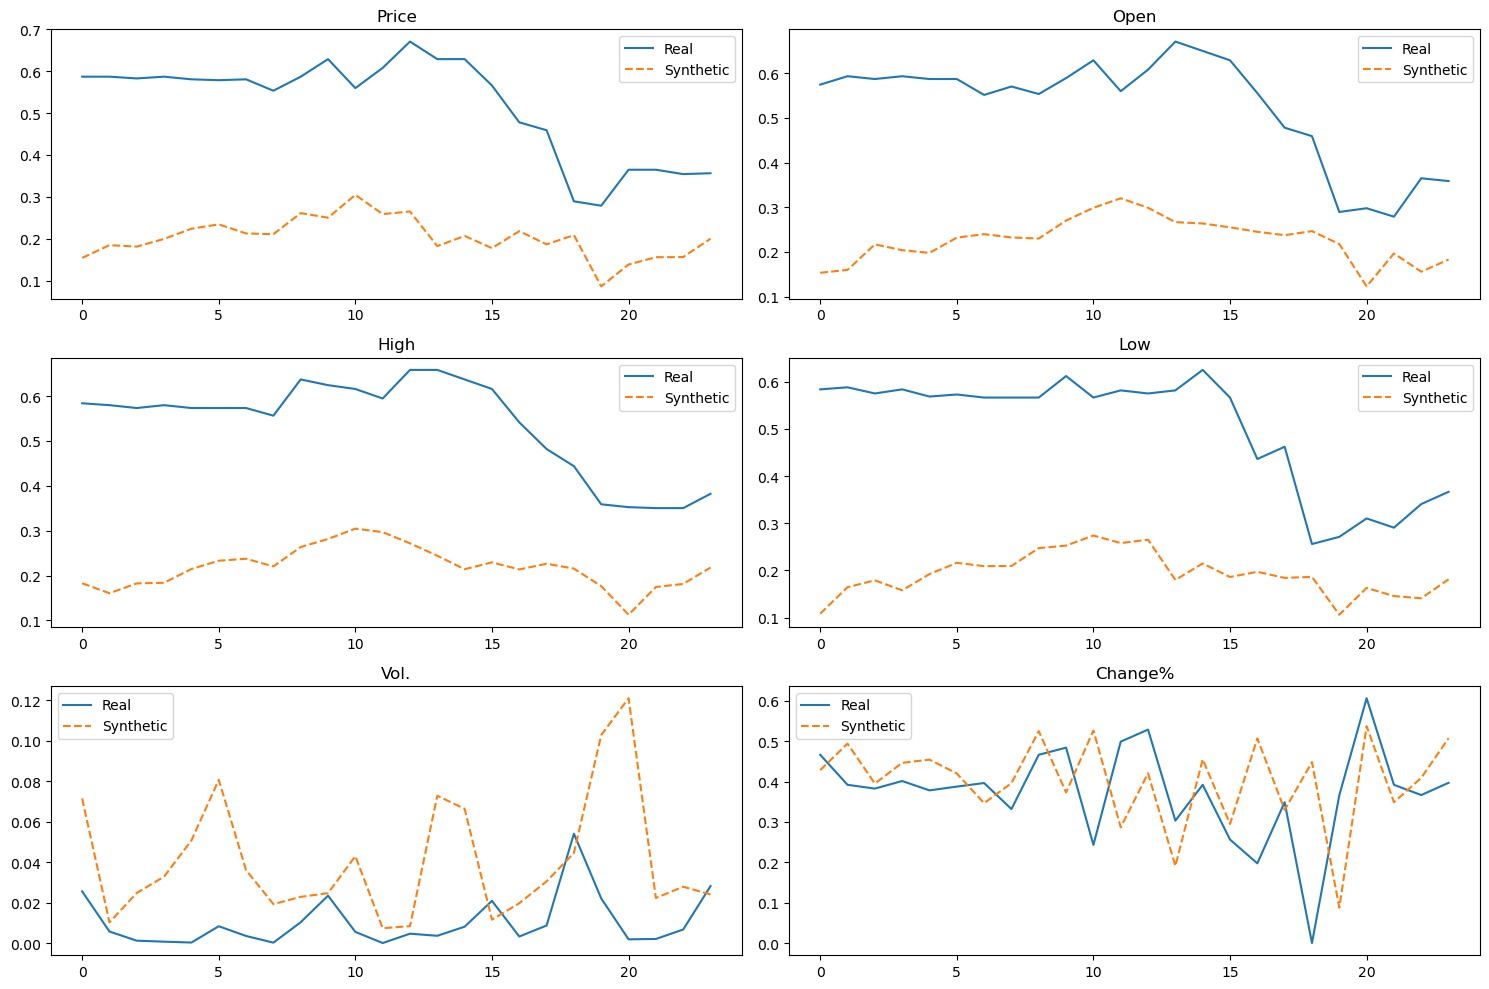

In [19]:
cols = ['Price','Open','High','Low','Vol.','Change%']                                                   #Visualizes how the synthetic data performed vs real data

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [12]:
from sklearn.decomposition import PCA                                                         #these libraries are imported, as we only need a small dimensional dataset
from sklearn.manifold import TSNE                                                             #implementing these allows us to extract data values that best represent the entire dataset
                                                                                              #this section focuses on creating two dataframes; one for real and one for synthetic
sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]                                  

real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

C:\Users\Dingus-Elite\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dingus-Elite\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
from tensorflow.keras import Input, Sequential                                                     #creating a simple GRU model for prediction
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [14]:
stock_data=np.asarray(stock_data)                                              #This section focuses on preparing the synthetic and real training data for prediction
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (350, 23, 6)
Real X train: (350, 23, 6)
Synthetic y train: (350, 6)
Real y train: (350, 6)
Real X test: (117, 23, 6)
Real y test: (117, 6)


In [16]:
ts_real = RNN_regression(12)                                                                               
early_stopping = EarlyStopping(monitor='val_loss')
#training the model with real data
real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=32,
                          callbacks=[early_stopping])

Epoch 1/200
11/11 [==============================] - 2s 41ms/step - loss: 0.2282 - val_loss: 0.2312
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 0.2198 - val_loss: 0.2229


In [17]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
3/3 [==============================] - 2s 179ms/step - loss: 0.2557 - val_loss: 0.2502
Epoch 2/200
3/3 [==============================] - 0s 19ms/step - loss: 0.2514 - val_loss: 0.2467


In [18]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

4/4 [==============================] - 0s 2ms/step


,r2,MAE,MRLE
Real,-3.734383,0.222878,0.040752
Synthetic,-4.080809,0.246716,0.044927


### 6. Model Tuning
Due to time constraints, there were no tuning in the model; as such the values listed here are the default values; a better score may be acquired if they are tuned, however.